In [2]:
#imports 
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import popsims
#splat.initializeStandards(all=True)
from scipy.interpolate import interp1d
import splat.empirical as spe

from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline




Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#splat.initializeStandards()

In [3]:
#functions
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=4.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1000, xerr=0.0)
    return vals, unc

def get_correct_filter_name(flt):
    #reformat from by 
    f= flt.split('_')
    if f[-1]=='ps1':
        return 'PANSTARRS_'+(f[0]).upper()
    else:
        return  flt
    
def get_best2018_relation(spt, flt):
    return spe.typeToMag(spt, flt, ref='best2018')

def get_colors(sp, flt1, flt2):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = filterMag(sp, flt1)
    #calculate the mag of the standard in J and H
    mag2, mag2_unc = filterMag(sp, flt2)
    #calculate the offset 
    return mag2-mag, (mag2_unc**2+ mag_unc**2)**0.5


def compute_colors(sp, sd=False):
    fl_pairs=None
    if sd: fl_pairs=sd_pairs
    if not sd: fl_pairs=dwarf_pairs

    res={}
    for p in fl_pairs.keys():
        flt=get_correct_filter_name(fl_pairs[p]['ref'])
        res.update({p+'and'+flt: \
                    get_colors(sp, p,flt)})
    return res

def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:   #use dwarfs for later than L5
            return  popsims.relations.spt_to_teff_pecaut(spt)
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return popsims.relations.spt_to_teff_pecaut(spt)
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return popsims.relations.teff_to_spt_pecaut(teff).flatten()[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return popsims.relations.teff_to_spt_pecaut(teff)

In [4]:
popsims.relations.spt_to_teff_pecaut(25)

1562.5779779721167

In [5]:
#dwarfs 
#first look at the previous absolute mag relations for optical
dwarf_pairs={'LSST_G': {'ref': 'g_ps1', 'method':'vega'},
            'LSST_R': {'ref': 'r_ps1', 'method':'vega'},
            'LSST_I': {'ref': 'i_ps1', 'method': 'vega'},
            'LSST_Y': {'ref': 'y_ps1', 'method': 'vega'},
            'LSST_Z':{'ref': 'z_ps1', 'method': 'vega'},
             
             #ADD SLOAN WHILE YOU'RE AT IT
            'SDSS_G': {'ref': 'g_ps1', 'method':'vega'},
            'SDSS_R': {'ref': 'r_ps1', 'method':'vega'},
            'SDSS_I': {'ref': 'i_ps1', 'method': 'vega'},
            'SDSS_Z':{'ref': 'z_ps1', 'method': 'vega'},
             
             #VISTA
            'VISTA_Z':{'ref': 'z_ps1', 'method': 'vega'},
            'VISTA_Y':{'ref': 'y_ps1', 'method': 'vega'},
           'VISTA_J': {'ref': '2MASS J', 'method': 'vega'},
            'VISTA_H': {'ref': '2MASS H', 'method': 'vega'},
             'VISTA_KS':{'ref': '2MASS K', 'method': 'vega'},
             
             #UKIDSS
            'UKIDSS_Y': {'ref': 'y_ps1', 'method': 'vega'},
            'UKIDSS_Z': {'ref': 'z_ps1', 'method': 'vega'},
            'UKIDSS_J': {'ref': '2MASS J', 'method': 'vega'},
            'UKIDSS_H': {'ref': '2MASS H' , 'method': 'vega'},
             'UKIDSS_K':{'ref': '2MASS K', 'method': 'vega'},
             
             #JWST
             'NIRISS_F090W': {'ref': 'r_ps1', 'method': 'vega'},
             'NIRISS_F115W': {'ref': '2MASS J', 'method': 'vega'},
             'NIRISS_F150W': {'ref': '2MASS J', 'method': 'vega'},
             'NIRISS_F200W': {'ref': '2MASS H', 'method': 'vega'},
             'NIRISS_F200W': {'ref': '2MASS H', 'method': 'vega'},
             
             'WFC3_F110W': {'ref': '2MASS J', 'method': 'vega'},
             'WFC3_F140W': {'ref': '2MASS J', 'method': 'vega'},
             'WFC3_F160W': {'ref': '2MASS H', 'method': 'vega'},
             
             #ROMAN
             'WFI_R062': {'ref': 'z_ps1', 'method': 'vega'},
             'WFI_Z087': {'ref': 'z_ps1', 'method': 'vega'},
             'WFI_Y106': {'ref': 'y_ps1', 'method': 'vega'},
             'WFI_J129': {'ref': '2MASS J', 'method': 'vega'},
             'WFI_H158': {'ref': '2MASS H', 'method': 'vega'},
             'WFI_F184': {'ref': '2MASS H', 'method': 'vega'},
             'WFI_Prism': {'ref': '2MASS J', 'method': 'vega'},
             'WFI_Grism': {'ref': '2MASS H', 'method': 'vega'},
             
             #EUCLID
             'EUCLID_Y': {'ref': 'y_ps1', 'method': 'vega'},
             'EUCLID_J': {'ref': '2MASS J', 'method': 'vega'},
             'EUCLID_H': {'ref': '2MASS H', 'method': 'vega'},
             
            'SUBARU_G': {'ref': 'g_ps1', 'method':'vega'},
            'SUBARU_R': {'ref': 'r_ps1', 'method':'vega'},
            'SUBARU_I': {'ref': 'i_ps1', 'method': 'vega'},
            'SUBARU_Z':{'ref': 'z_ps1', 'method': 'vega'},
             
            'DECAM_G': {'ref': 'g_ps1', 'method':'vega'},
            'DECAM_R': {'ref': 'r_ps1', 'method':'vega'},
            'DECAM_I': {'ref': 'i_ps1', 'method': 'vega'},
            'DECAM_Y': {'ref': 'y_ps1', 'method': 'vega'},
            'DECAM_Z':{'ref': 'z_ps1', 'method': 'vega'}}

#first look at the previous absolute mag relations for optical
#dwarf_pairs={'LSST_G': {'ref': 'g_ps1', 'method':'vega'},
#            'LSST_R': {'ref': 'r_ps1', 'method':'vega'},
#            'LSST_I': {'ref': 'i_ps1', 'method': 'vega'},
#            'LSST_Y': {'ref': 'y_ps1', 'method': 'vega'},
#            'LSST_Z':{'ref': 'z_ps1', 'method': 'vega'}}

In [6]:
spgrid=np.arange(10, 40)

In [1]:
#GET TEMPLATES=
dwarf_tpls= np.load('/Volumes/LaCie/popsimsdata/dwarfs_templates.npy',  allow_pickle=True)[0]
FITS= np.load('/Volumes/LaCie/popsimsdata//abs_mag_relations.npy', allow_pickle=True)[0]

NameError: name 'np' is not defined

In [8]:
len([x.name for x in dwarf_tpls['spectra'] if 'Aurora' in x.name])

25

In [9]:
splat.searchLibrary().columns

Index(['SOURCE_KEY', 'NAME', 'DESIGNATION', 'RA', 'DEC', 'DISCOVERY_REFERENCE',
       'OPT_TYPE', 'OPT_TYPE_REF', 'NIR_TYPE', 'NIR_TYPE_REF', 'LIT_TYPE',
       'LIT_TYPE_REF', 'OBJECT_TYPE', 'J_2MASS', 'J_2MASS_E', 'H_2MASS',
       'H_2MASS_E', 'KS_2MASS', 'KS_2MASS_E', 'JK_EXCESS', 'COLOR_EXTREMITY',
       'LUMINOSITY_CLASS', 'METALLICITY_CLASS', 'GRAVITY_CLASS_OPTICAL',
       'GRAVITY_CLASS_OPTICAL_REF', 'GRAVITY_CLASS_NIR',
       'GRAVITY_CLASS_NIR_REF', 'CLUSTER', 'CLUSTER_REF', 'LIBRARY', 'BINARY',
       'BINARY_REF', 'SBINARY', 'SBINARY_REF', 'COMPANION_NAME',
       'COMPANION_REF', 'SIMBAD_OTYPE', 'SIMBAD_NAME', 'SIMBAD_SPT',
       'SIMBAD_SPT_REF', 'SIMBAD_SEP', 'PARALLAX', 'PARALLAX_E',
       'PARALLEX_REF', 'DISTANCE_PHOT', 'DISTANCE_PHOT_E', 'DISTANCE',
       'DISTANCE_E', 'MU', 'MU_E', 'MU_RA', 'MU_DEC', 'MU_REF', 'VTAN',
       'VTAN_E', 'RV', 'RV_E', 'RV_REF', 'VSINI', 'VSINI_E', 'VSINI_REF',
       'NOTE', 'SELECT', 'DATA_KEY', 'DATA_FILE', 'INSTRUMENT',
     

In [10]:
get_correct_filter_name('2MASS J')

'2MASS J'

In [11]:
#compute color corrections
color_corrections=[ compute_colors(sp, sd=False) for sp in tqdm(dwarf_tpls['spectra'])]

100%|█████████████████████████████████████████| 296/296 [10:19<00:00,  2.09s/it]


In [12]:
df_dwarfs=pd.DataFrame.from_records(color_corrections)
df_dwarfs['spt']= dwarf_tpls['spt']
df_dwarfs['teff']= [ spt_to_teff(x, sd=False) for x in df_dwarfs.spt]

In [13]:
from scipy.interpolate import UnivariateSpline

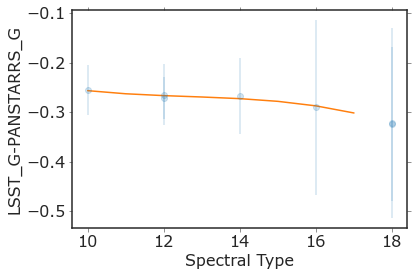

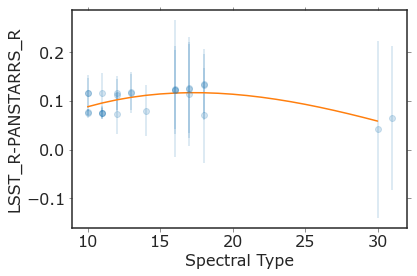

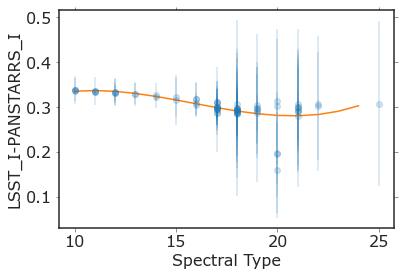

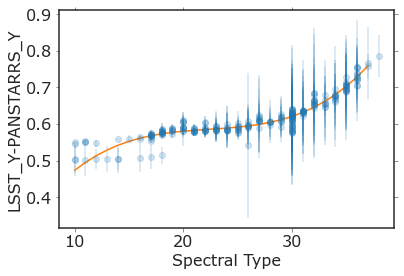

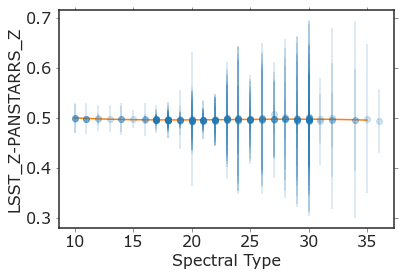

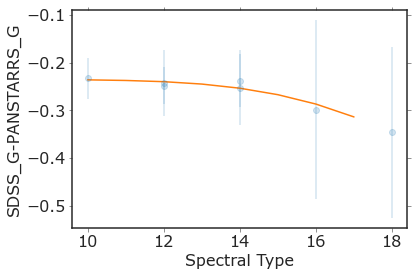

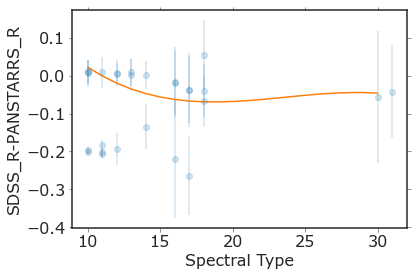

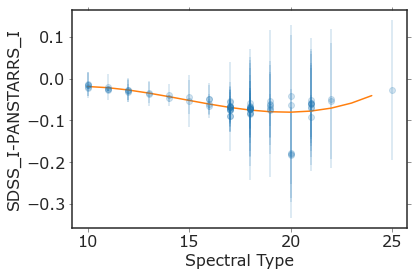

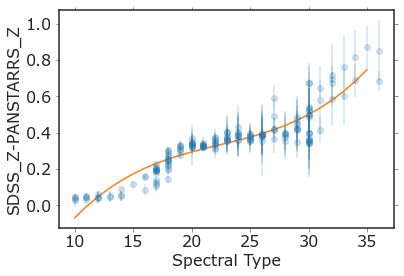

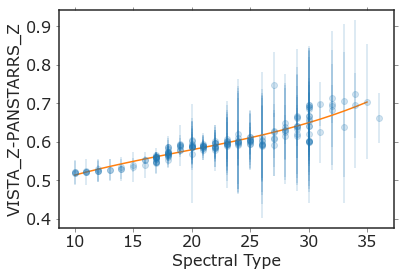

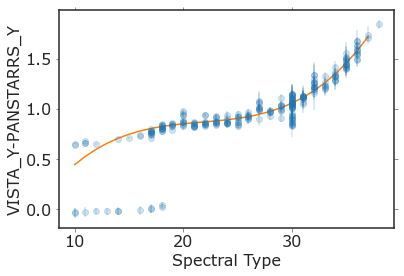

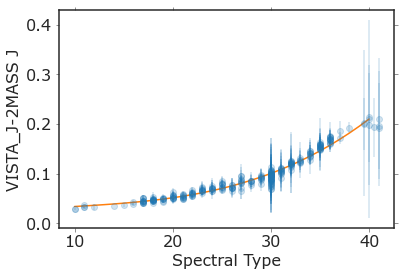

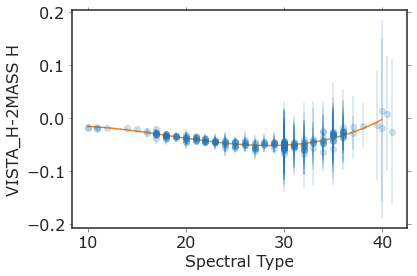

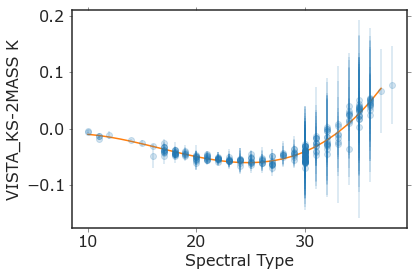

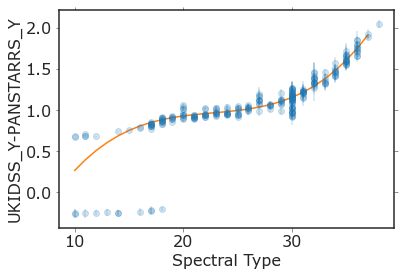

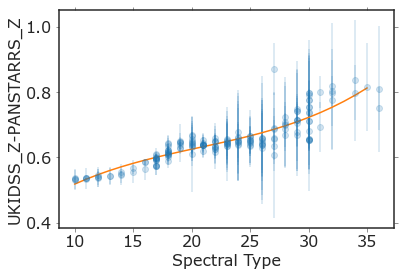

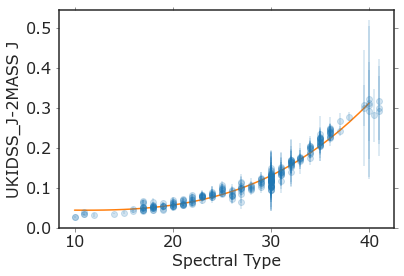

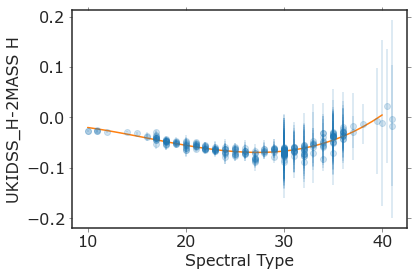

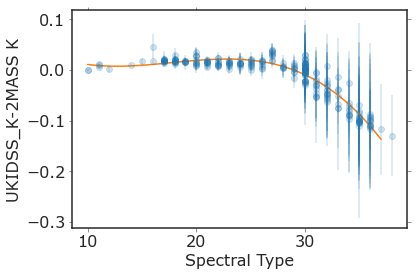

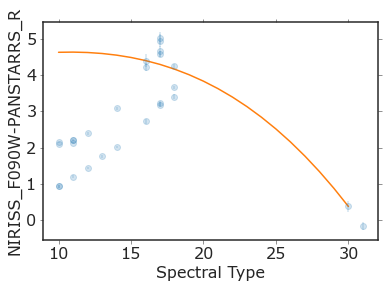

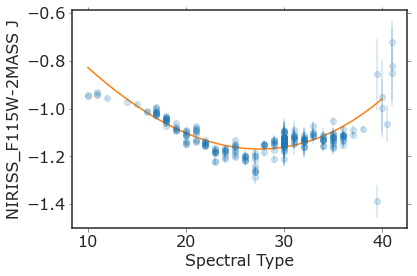

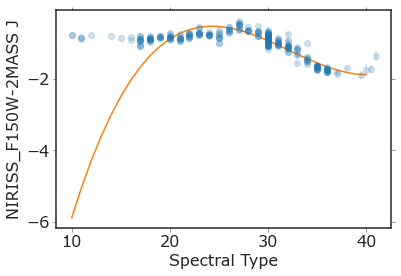

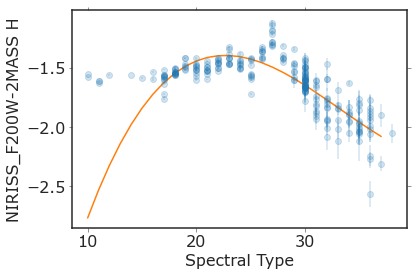

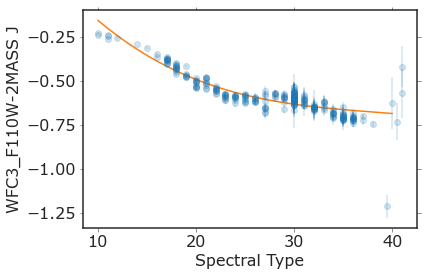

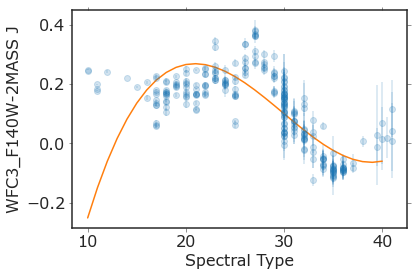

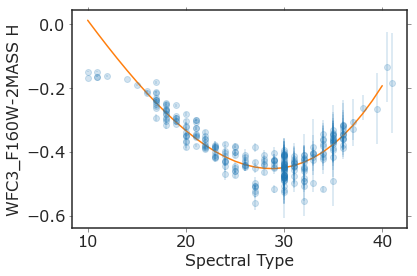

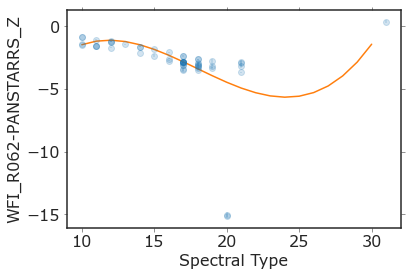

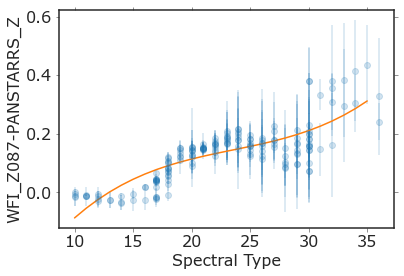

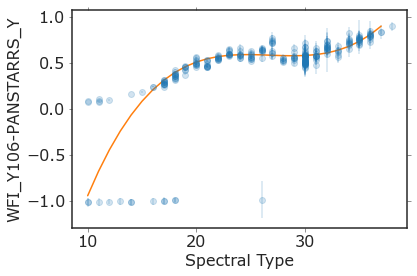

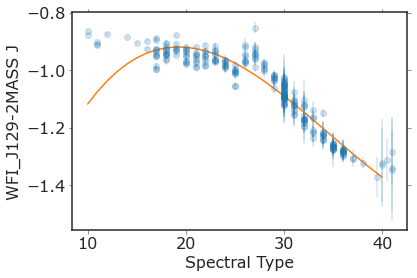

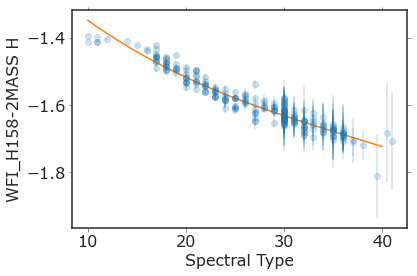

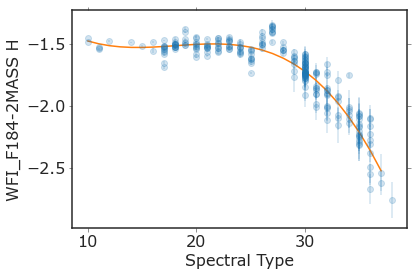

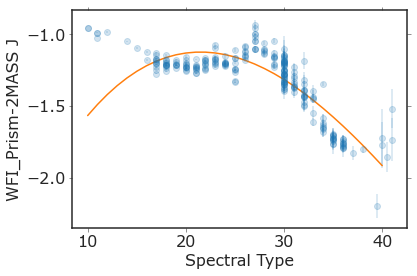

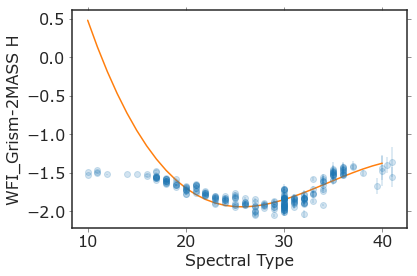

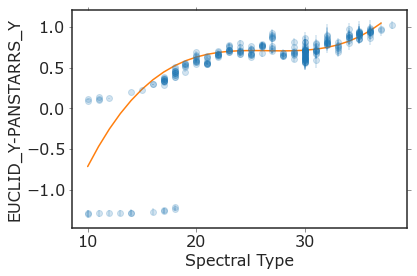

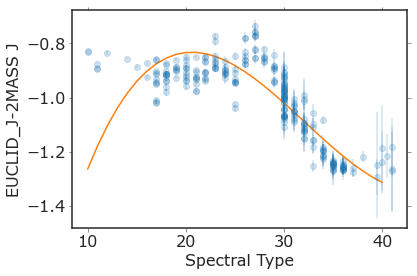

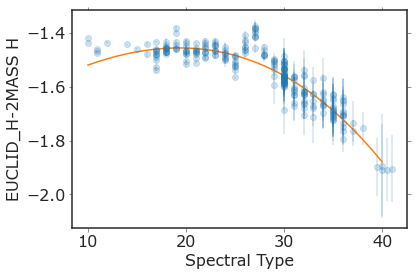

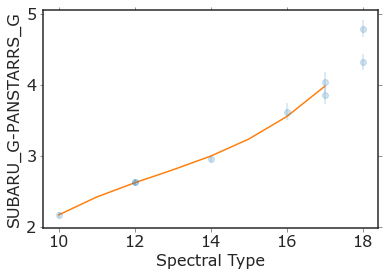

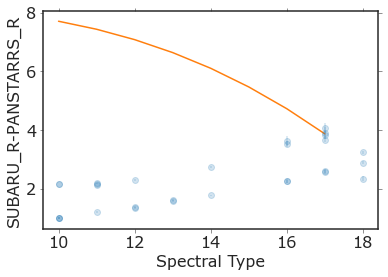

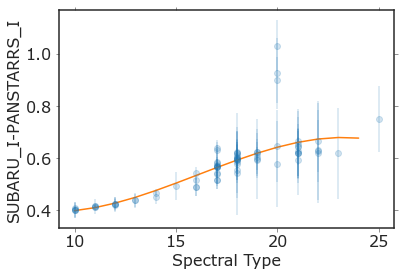

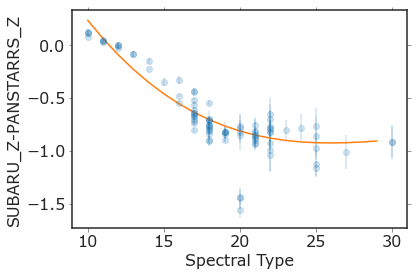

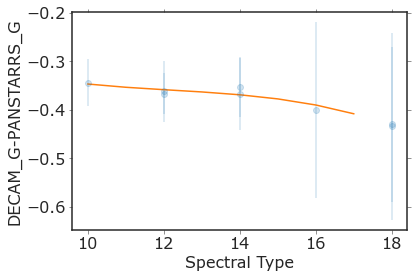

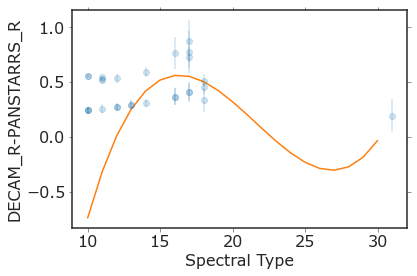

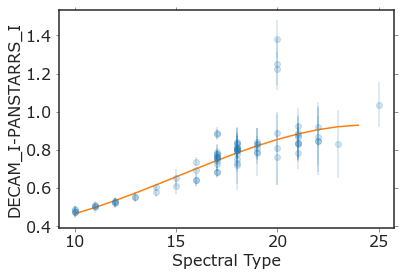

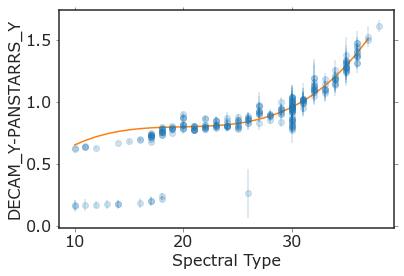

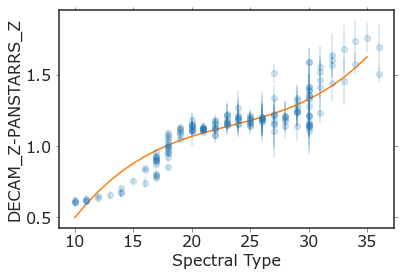

In [14]:
#fit to color corrections
cols=[k for k in df_dwarfs.keys() if k not in ['spt', 'teff']]
for k in cols:
        fig, ax=plt.subplots()

        mask= ~np.logical_or.reduce([np.isnan(df_dwarfs.spt.values), 
                                    np.isnan( np.vstack(df_dwarfs[k].values)[:,0]),
                                    np.isnan(np.vstack(df_dwarfs[k].values)[:,1]),
                                    np.vstack(df_dwarfs[k].values)[:,1] > 2e-1])
         #FIT
        x=df_dwarfs.spt.values.astype(float)[mask]
        y= np.vstack(df_dwarfs[k].values)[:,0][mask]
        yerr= np.vstack(df_dwarfs[k].values)[:,1][mask]
        #mask models that are nans

        m, fit= fit_with_nsigma_clipping(x, y, yerr, 3, sigma=3.)
        
        #try:

        #    fit= UnivariateSpline(x[np.argsort(x)], y[np.argsort(x)])
        #except:
        #    pass




        FITS['colors_spt']['dwarfs'].update({k: {'x': 'spt',
                                              'y': k,
                                              'fit':list(fit.coeffs), \
                                              'scatter': np.nanmedian(yerr), \
                                              'method': 'spline',\
                                              'range':  (np.nanmin(x),\
                                                         np.nanmax(x)), \
                                             'x0':0.}})

        xlim=(np.nanmin(x),\
                                                         np.nanmax(x))
        xgrid=np.arange(xlim[0], xlim[1])

        ylim=fit(list(xlim))

        ylim=[ylim[0]-5*np.nanmedian(yerr), ylim[-1]+5*np.nanmedian(yerr)]
        xlim=[xlim[0]-1, xlim[1]+1]

        ax.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.2)
        ax.plot(xgrid, fit(xgrid) )

        ax.set(xlabel='Spectral Type', ylabel=k.replace('and', '-'))

In [15]:
#use freezer et al for >16
gs= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_G')
rs=compute_mags_from_reference(dwarf_tpls['spt'], 'r_ps1', 'freeser2022')
imags=compute_mags_from_reference(dwarf_tpls['spt'], 'i_ps1', 'freeser2022')
zs=compute_mags_from_reference(dwarf_tpls['spt'], 'z_ps1', 'freeser2022')
ys=compute_mags_from_reference(dwarf_tpls['spt'], 'y_ps1', 'freeser2022')

#use beset et al for <16
best_gs= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_G')
best_rs= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_R')
best_is= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_I')
best_zs= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_Z')
best_ys= get_best2018_relation(dwarf_tpls['spt'], 'PANSTARRS_Y')

#mask
mask= df_dwarfs['spt']<=20

In [16]:
df_dwarfs['PANSTARRS_G']=gs[0]
df_dwarfs['PANSTARRS_G_er']=gs[1]
df_dwarfs['PANSTARRS_R']=rs[0]
df_dwarfs['PANSTARRS_R_er']=rs[1]
df_dwarfs['PANSTARRS_I']=imags[0]
df_dwarfs['PANSTARRS_I_er']=imags[1]
df_dwarfs['PANSTARRS_Z']=zs[0]
df_dwarfs['PANSTARRS_Z_er']=zs[1]
df_dwarfs['PANSTARRS_Y']=ys[0]
df_dwarfs['PANSTARRS_Y_er']=ys[1]

df_dwarfs['PANSTARRS_G'][mask]=best_gs[0][mask]
df_dwarfs['PANSTARRS_G_er'][mask]=best_gs[1][mask]
df_dwarfs['PANSTARRS_R'][mask]=best_rs[0][mask]
df_dwarfs['PANSTARRS_R_er'][mask]=best_rs[1][mask]
df_dwarfs['PANSTARRS_I'][mask]=best_is[0][mask]
df_dwarfs['PANSTARRS_I_er'][mask]=best_is[1][mask]
df_dwarfs['PANSTARRS_Z'][mask]=best_zs[0][mask]
df_dwarfs['PANSTARRS_Z_er'][mask]=best_zs[1][mask]
df_dwarfs['PANSTARRS_Y'][mask]=best_ys[0][mask]
df_dwarfs['PANSTARRS_Y_er'][mask]=best_ys[1][mask]

#add uncertainties

In [17]:
def get_j_mag(spt):
    if spt <=20:
        return popsims.relations.absolute_mag_from_spt(spt, mag='j', ref='dupuy2012', syst='2mass')
    else:
        return popsims.relations.absolute_mag_from_spt(spt, mag='j', ref='dupuy2012', syst='2mass')
    
def get_h_mag(spt):
    if spt <=20:
        return popsims.relations.absolute_mag_from_spt(spt, mag='h', ref='dupuy2012', syst='2mass')
    else:
        return popsims.relations.absolute_mag_from_spt(spt, mag='h', ref='dupuy2012', syst='2mass')
        
def get_k_mag(spt):
    if spt <=20:
        return  popsims.relations.absolute_mag_from_spt(spt, mag='ks', ref='dupuy2012', syst='2mass')
    else:
        return  popsims.relations.absolute_mag_from_spt(spt, mag='k', ref='freeser2022', syst='2mass')

In [18]:
get_j_mag(20)

(11.61696103497141, 0.39388595017217837)

In [19]:
js=np.vstack( [ get_j_mag(x) for x in df_dwarfs.spt.values])
hs=np.vstack( [ get_h_mag(x) for x in df_dwarfs.spt.values])
ks=np.vstack( [ get_k_mag(x) for x in df_dwarfs.spt.values])
df_dwarfs['2MASS J']= js[:,0]
df_dwarfs['2MASS H']= hs[:,0]
df_dwarfs['2MASS K']= ks[:,0]
df_dwarfs['2MASS J_er']= js[:,1]
df_dwarfs['2MASS H_er']= hs[:,1]
df_dwarfs['2MASS K_er']= ks[:,1]

[Text(0.5, 0, 'Spectral Type'), Text(0, 0.5, 'K 2MASS')]

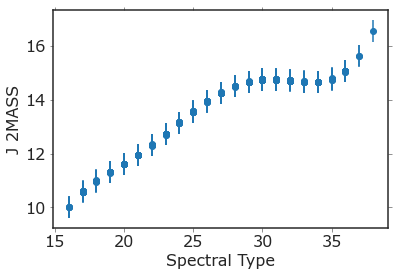

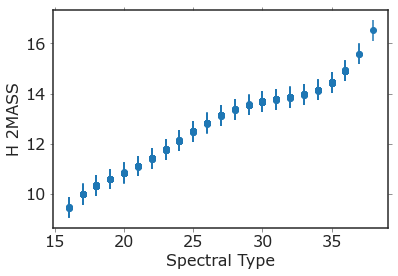

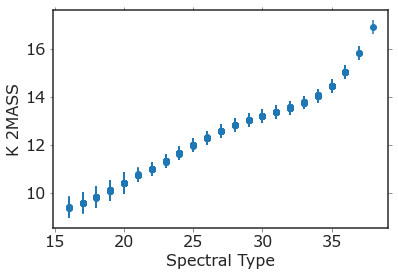

In [20]:
fig, ax=plt.subplots()
ax.errorbar(df_dwarfs.spt.values, js[:,0], yerr=js[:,1], fmt='o')
ax.set(xlabel='Spectral Type', ylabel='J 2MASS')

fig, ax=plt.subplots()
ax.errorbar(df_dwarfs.spt.values, hs[:,0], yerr=hs[:,1], fmt='o')
ax.set(xlabel='Spectral Type', ylabel='H 2MASS')


fig, ax=plt.subplots()
ax.errorbar(df_dwarfs.spt.values, ks[:,0], yerr=ks[:,1], fmt='o')
ax.set(xlabel='Spectral Type', ylabel='K 2MASS')

In [21]:
#popsims.relations.absolute_mag_from_spt(30, mag='k', ref='freeser2022', syst='2mass')

In [22]:
#compute absolute magnitudes
for k in dwarf_pairs.keys():
    #compute corr
    ref_k= get_correct_filter_name(dwarf_pairs[k]['ref'])
    corrk=   k+'and'+ref_k
    mags= df_dwarfs[ref_k]+np.vstack(df_dwarfs[corrk])[:,0]
    unc= (df_dwarfs[ref_k+'_er']**2+np.vstack(df_dwarfs[corrk])[:,1]**2)**0.5
    
    df_dwarfs[k]= mags
    df_dwarfs[k+'_er']=unc
    print (k, np.nanmedian(unc))
    

LSST_G 0.6074933071567334
LSST_R 1.2606741626902787
LSST_I 0.90273251120666
LSST_Y 0.36355719174540035
LSST_Z 0.37542728399516145
SDSS_G 0.6165104451803759
SDSS_R 1.315700546412324
SDSS_I 0.868215950298387
SDSS_Z 0.3683620087476609
VISTA_Z 0.37112542257549985
VISTA_Y 0.362022020388328
VISTA_J 0.40107416519592476
VISTA_H 0.40144471226503775
VISTA_KS 0.28471061474031356
UKIDSS_Y 0.3618396033255035
UKIDSS_Z 0.37101720542889943
UKIDSS_J 0.40094294933161967
UKIDSS_H 0.40146076292482835
UKIDSS_K 0.28510771272107116
NIRISS_F090W 0.9314004741128167
NIRISS_F115W 0.40100957909358403
NIRISS_F150W 0.40148694990782036
NIRISS_F200W 0.40254894487430354
WFC3_F110W 0.4013828254365483
WFC3_F140W 0.40123100481709234
WFC3_F160W 0.401687849407106
WFI_R062 0.931640625900264
WFI_Z087 0.3708790830125836
WFI_Y106 0.3615754033860617
WFI_J129 0.4012464982887436
WFI_H158 0.4016456143539082
WFI_F184 0.40311313365835055
WFI_Prism 0.40148617802514747
WFI_Grism 0.4016907937398325
EUCLID_Y 0.36167416919085155
EUCLID_J

In [23]:
line_models=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_line2021.npy', allow_pickle=True)[0]
line_models_bool=line_models['z']==0.0

In [24]:
model_vals=dict(zip(dwarf_pairs.keys(), []))

#compute values from filtermags
for k in dwarf_pairs.keys():
    mags= np.vstack([filterMag(x, k) for x in np.array(line_models['spectra'])[line_models_bool]])
    
    model_vals[k]=mags[:,0] 
    model_vals[k+'_er']=np.nanmedian(df_dwarfs[k+'_er'][df_dwarfs[k+'_er']<1.])
    
model_line_df=pd.DataFrame(model_vals)

model_line_df['spt']=[ teff_to_spt(x, sd=False) for x in np.array(line_models['teff'])[line_models_bool]]
model_line_df['teff']= np.array(line_models['teff'])[line_models_bool]
model_line_df=model_line_df.applymap(lambda x: float(x))


In [25]:
#ADD models
models=np.load('/Volumes/LaCie/popsimsdata/dwarfs_models.npy', allow_pickle=True)[0]
model_vals=dict(zip(dwarf_pairs.keys(), []))

#compute values from filtermags
for k in dwarf_pairs.keys():
    mags= np.vstack([filterMag(x, k) for x in models['spectra']])
    
    model_vals[k]=mags[:,0] 
    model_vals[k+'_er']=np.nanmedian(df_dwarfs[k+'_er'][df_dwarfs[k+'_er']<1.])
    
model_df=pd.DataFrame(model_vals)

model_df['spt']=[ teff_to_spt(x, sd=False) for x in models['teff']]
model_df['teff']= models['teff']
model_df=model_df.applymap(lambda x: float(x))
#model_df=pd.concat([model_line_df, model_df])

In [26]:
#model_df= model_line_df

In [27]:
#add will best's sample
#rename some columns
best_columns={}
for k in ['g', 'r', 'i', 'z', 'y']:
    best_columns.update({'absolute_PS1{}mag'.format(k):'PANSTARRS_{}'.format(k.upper())})
    best_columns.update({'absolute_PS1{}mag_er'.format(k):'PANSTARRS_{}_er'.format(k.upper())})
    best_columns.update({'use_mag_PS1{}mag'.format(k): 'use_PANSTARRS_{}'.format(k.upper())})
    

for k in ['J','H']:
    best_columns.update({'absolute_{}mag'.format(k): '2MASS {}'.format(k)})
    best_columns.update({'absolute_{}mag_er'.format(k): '2MASS {}_er'.format(k)})
    best_columns.update({'use_mag_{}mag'.format(k): 'use_2MASS {}'.format(k)})

#using Ks and K interchangably
for k in ['K']:
    best_columns.update({'absolute_{}smag'.format(k): '2MASS {}'.format(k)})
    best_columns.update({'absolute_{}smag_er'.format(k): '2MASS {}_er'.format(k)})
    best_columns.update({'use_mag_{}smag'.format(k): 'use_2MASS {}'.format(k)})

best_sample= pd.read_pickle('/Volumes/LaCie/Best2018_masked.csv.gz').rename(columns=best_co#use the color relation to compute correction and glags
for k in dwarf_pairs.keys():
    #compute corr
    ref_k= get_correct_filter_name(dwarf_pairs[k]['ref'])
    
    corrk=   k+'and'+ref_k
    #pol= np.poly1d(FITS['colors_spt']['dwarfs'][corrk]['fit'])
    scatter=(FITS['colors_spt']['dwarfs'][corrk]['scatter'])
    
    pol= np.poly1d(FITS['colors_spt']['dwarfs'][corrk]['fit'])
    
    corrval= pol(best_sample.NumType.values)
    
    mags= best_sample[ref_k]+corrval
    unc= (best_sample[ref_k+'_er']**2+ scatter**2)**0.5
    
    best_sample[k]= mags
    best_sample[k+'_er']=unc
    best_sample['use_{}'.format(k)]=best_sample['use_{}'.format(ref_k)]

In [28]:
best_sample['spt']=best_sample.NumType.values.astype(float)
best_sample['teff']=[ spt_to_teff(x, sd=False) for x in best_sample.spt.values]

In [29]:
ABS_MAG_USED={}

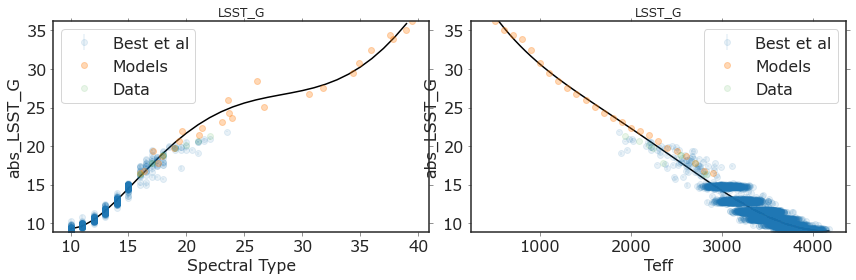

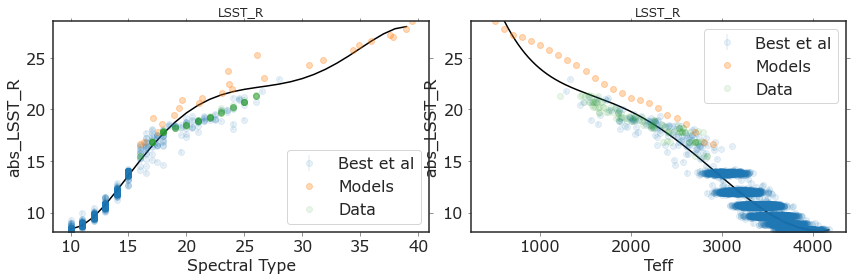

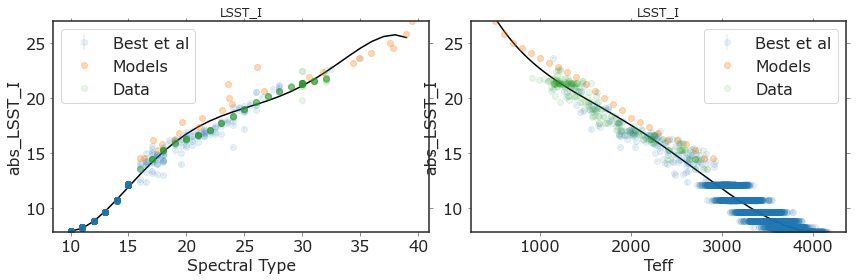

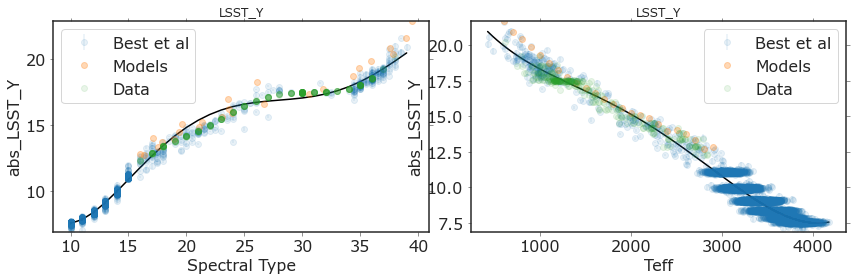

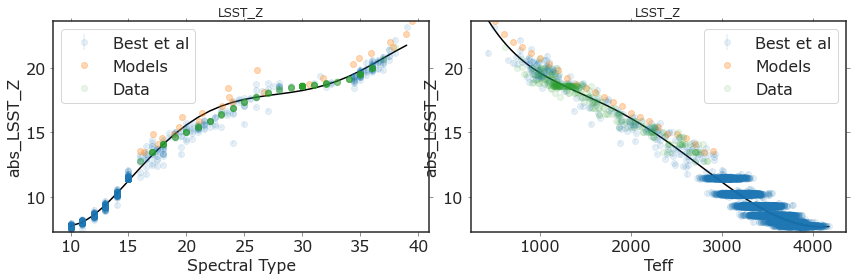

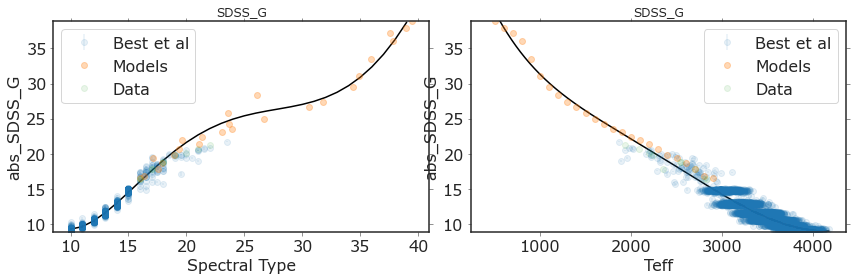

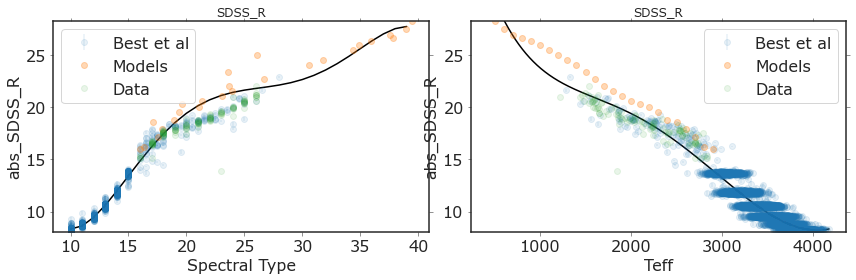

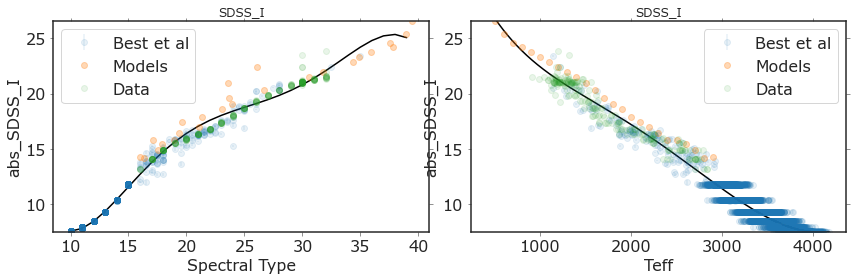

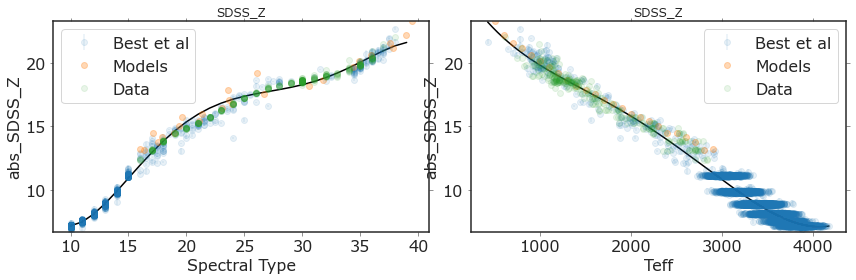

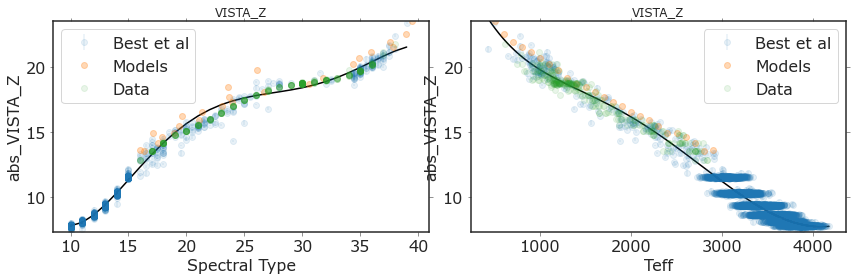

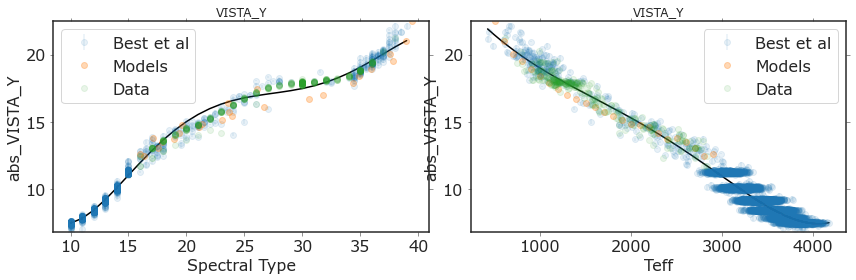

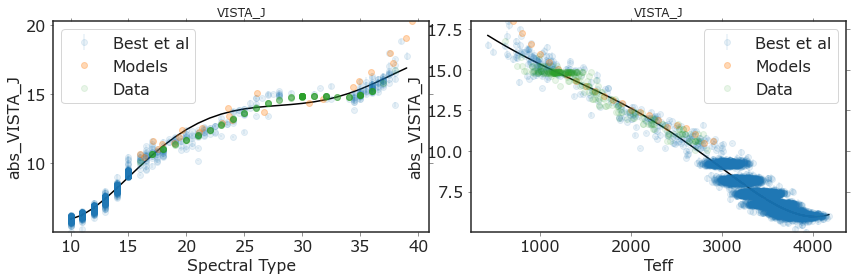

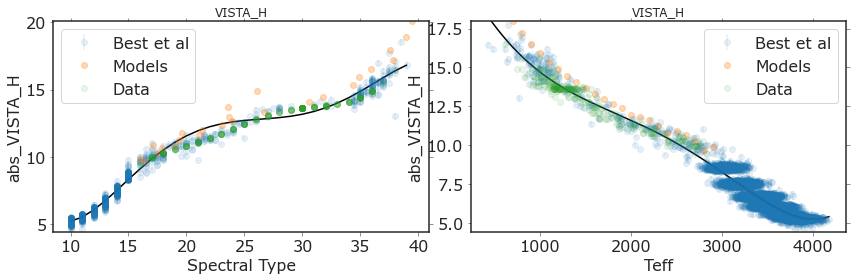

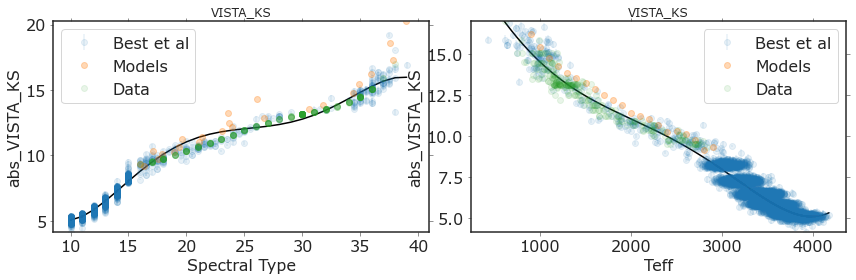

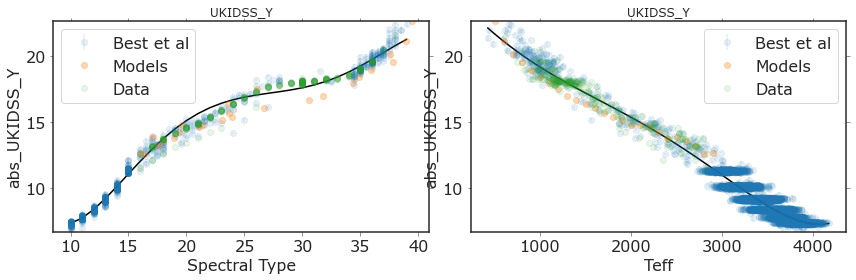

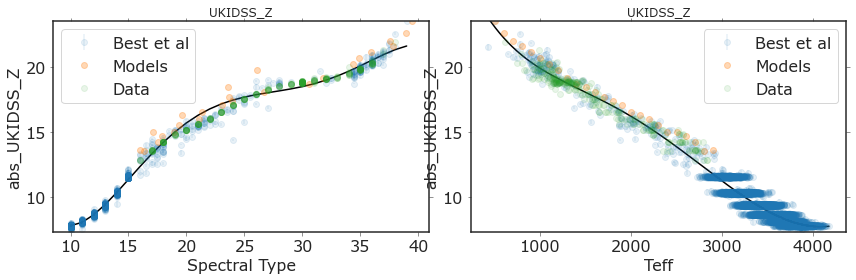

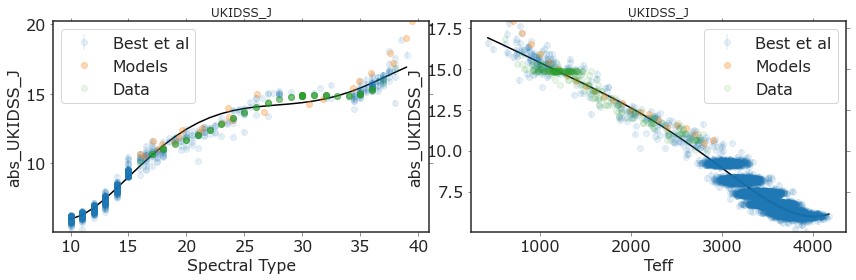

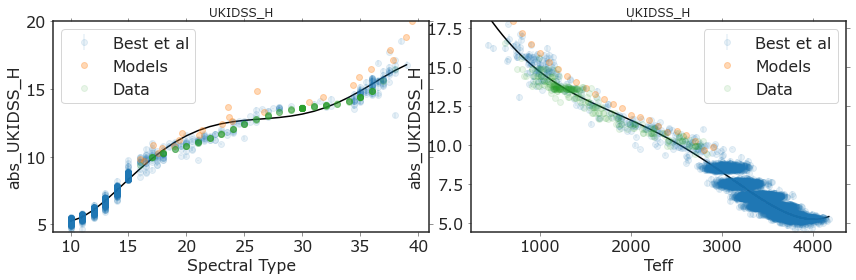

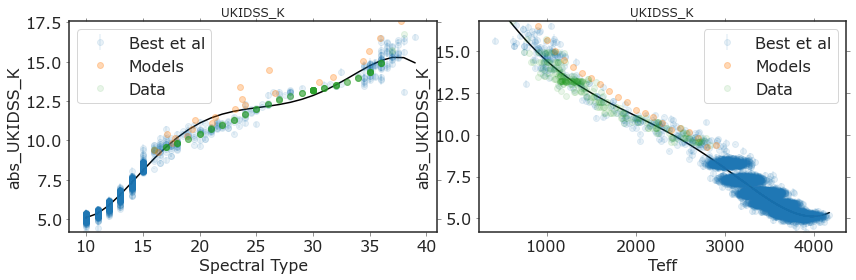

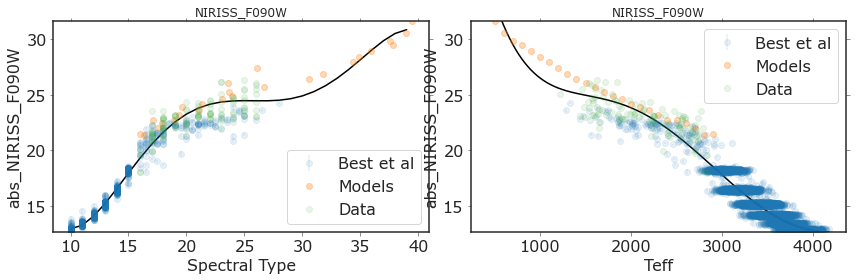

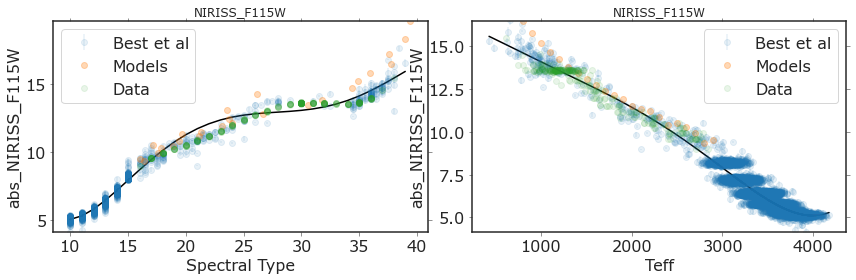

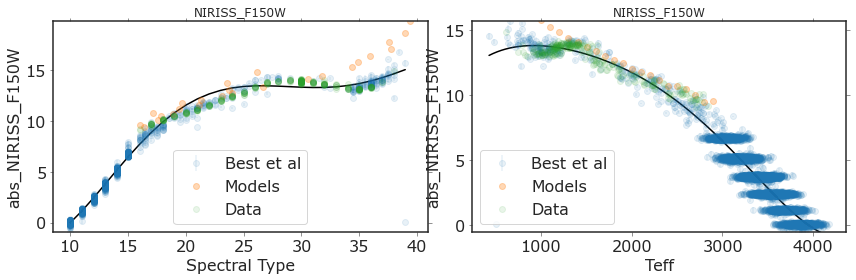

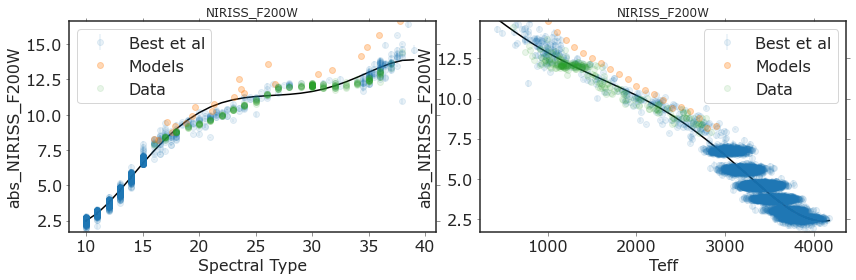

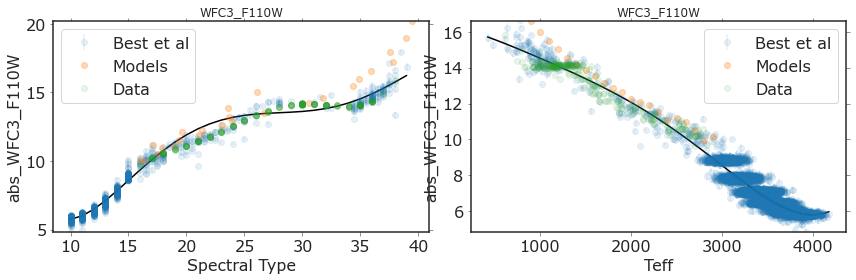

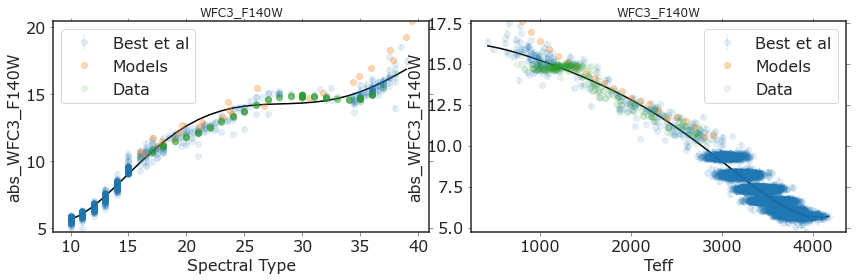

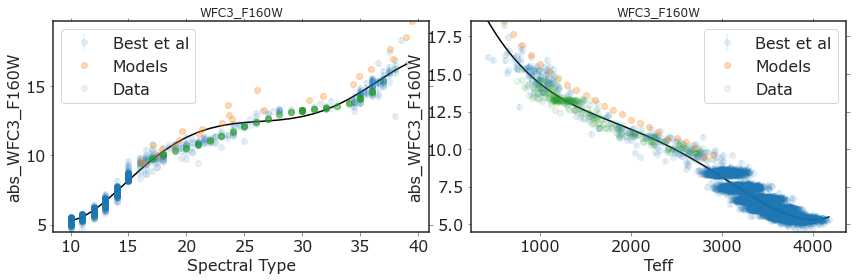

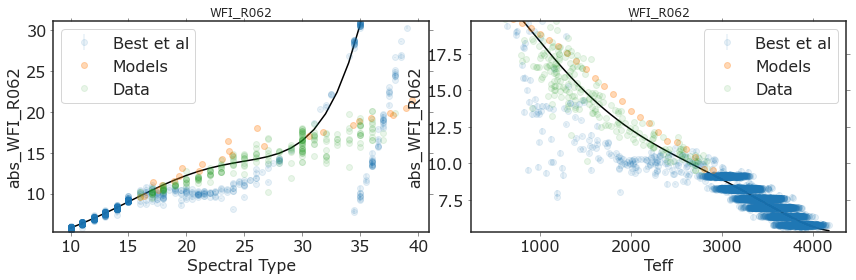

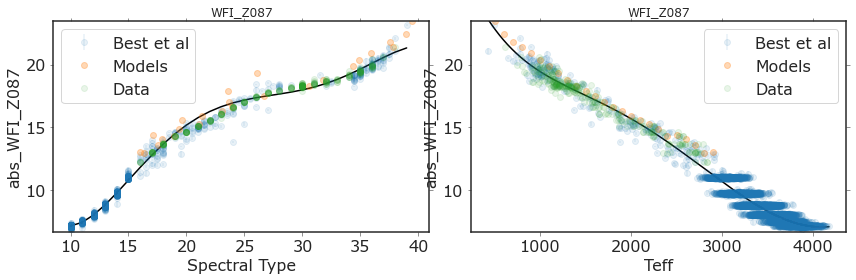

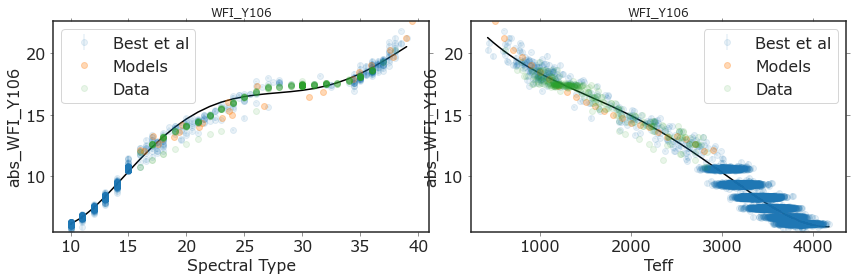

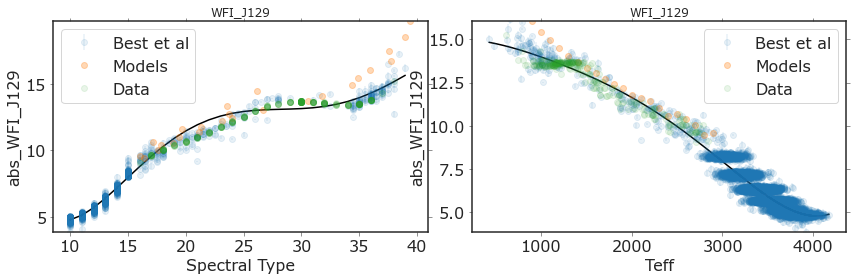

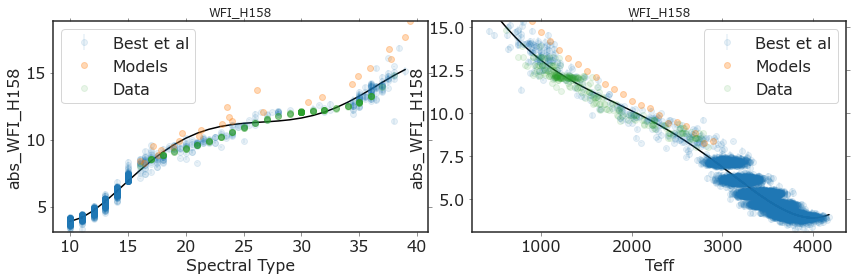

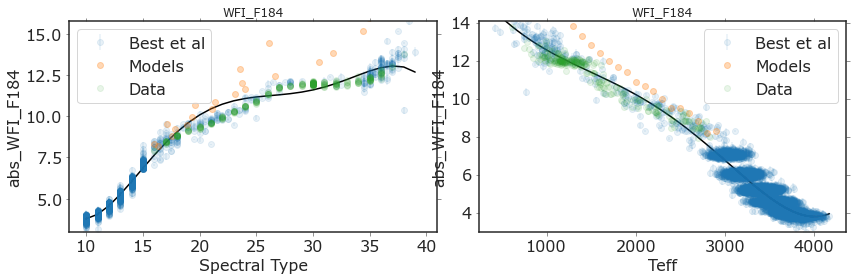

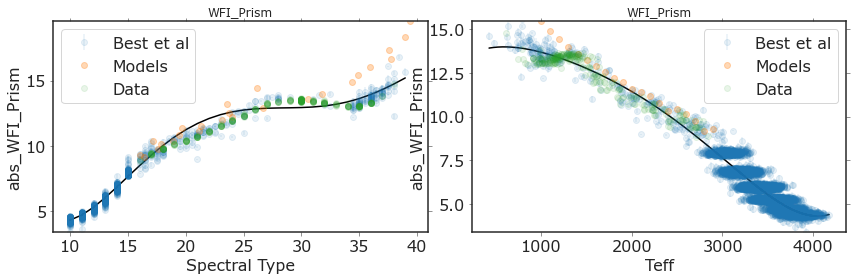

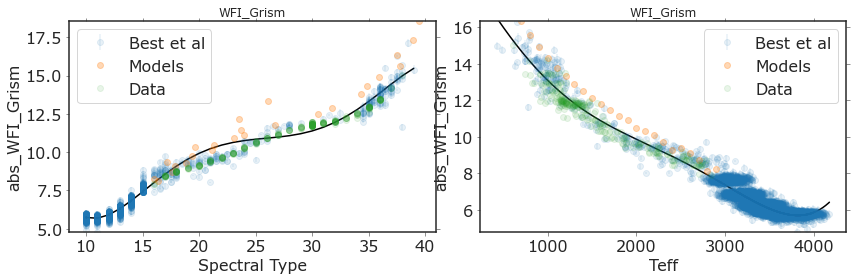

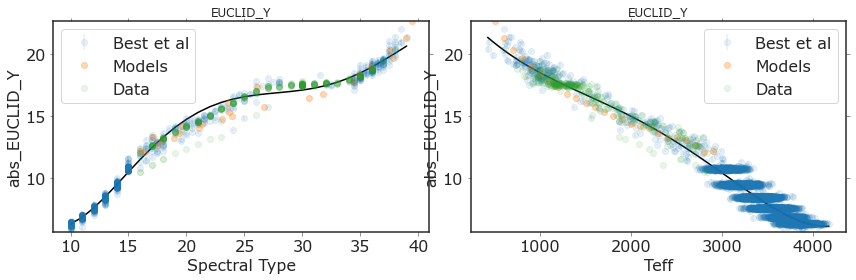

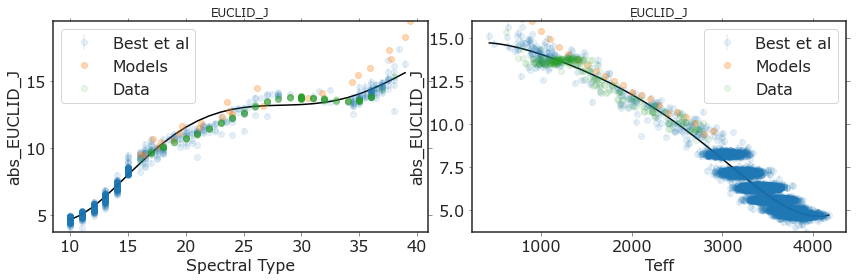

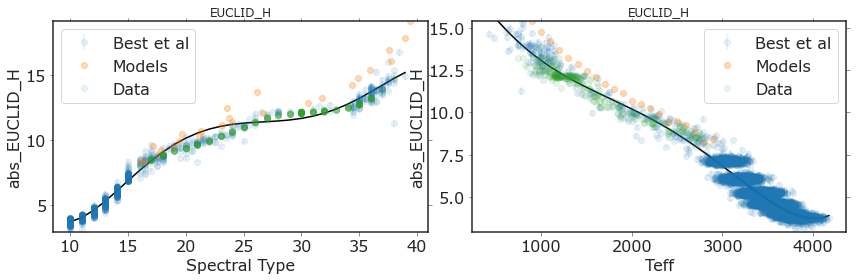

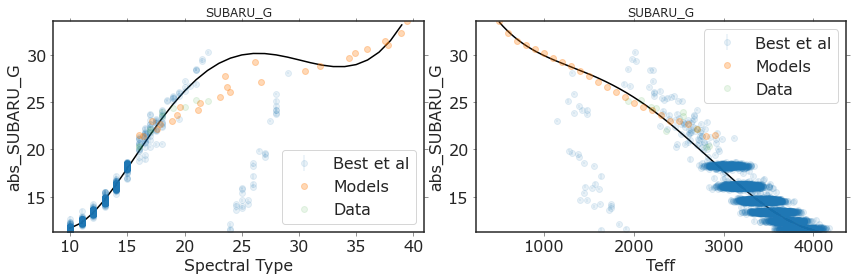

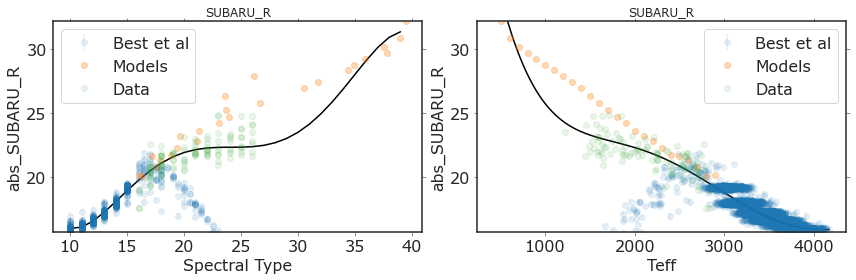

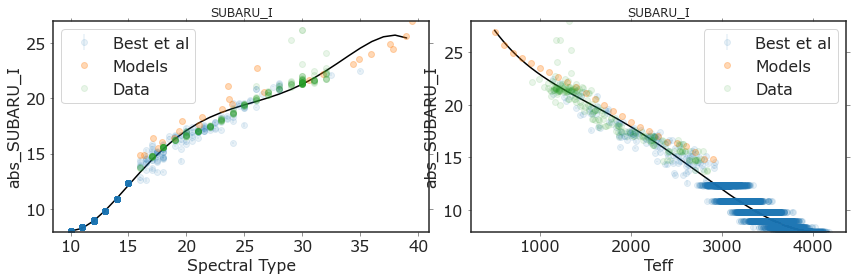

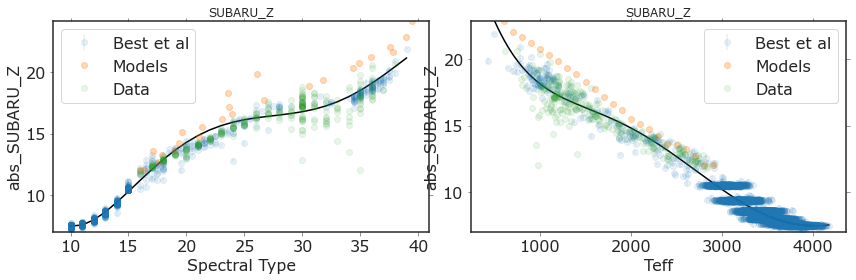

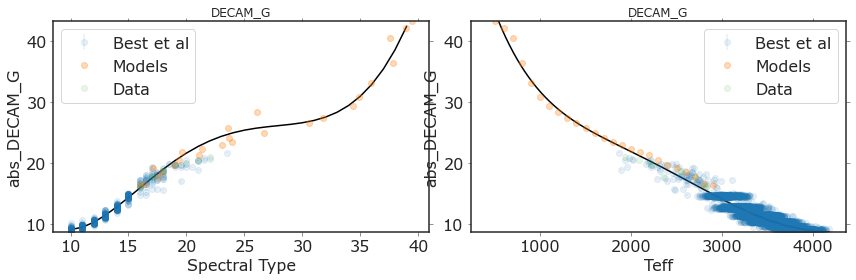

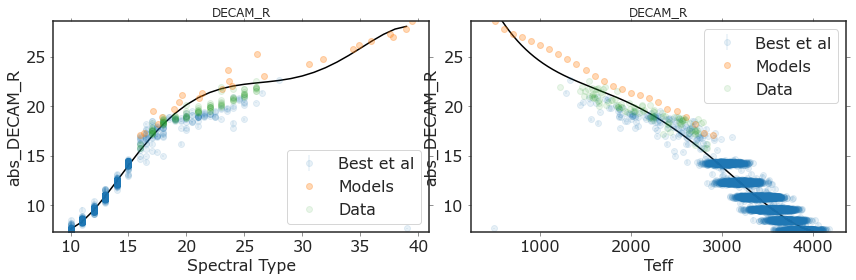

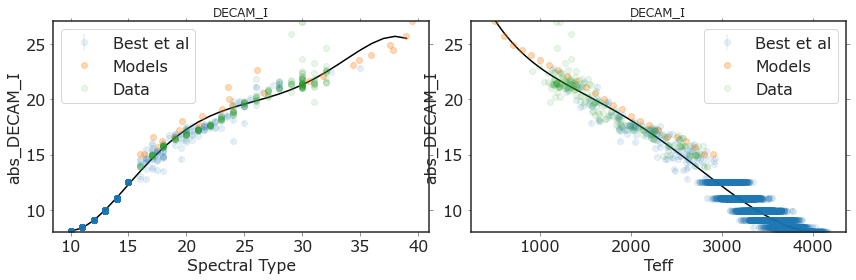

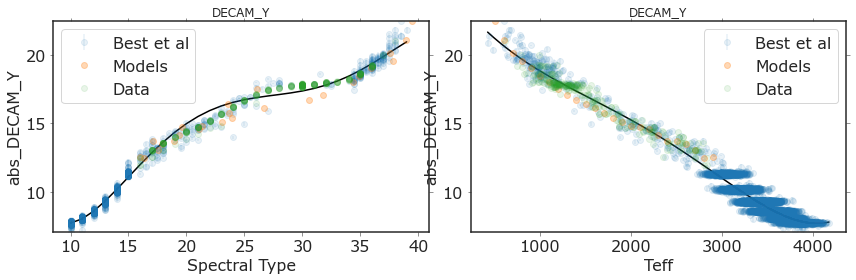

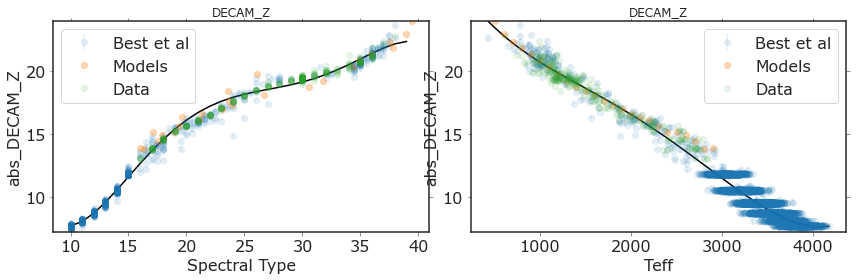

In [30]:
#visualize and fit 
for k in  dwarf_pairs.keys():
    fig, (ax, ax1)=plt.subplots(figsize=(12, 4), ncols=2)
    
    offset= np.nanmedian(df_dwarfs[k][df_dwarfs.teff.between(2500, 3000)])-np.nanmedian(model_df[k][model_df.teff.between(2500, 3000)])
   
    
    
    ax.errorbar(best_sample.spt, best_sample[k], yerr=best_sample[k+'_er'], fmt='o', alpha=0.1, label='Best et al')
    ax1.errorbar(best_sample.teff, best_sample[k], yerr=best_sample[k+'_er'], fmt='o', alpha=0.1, label='Best et al')
    
     
    ax.errorbar(model_df.spt, model_df[k]+offset, fmt='o', alpha=0.3, label='Models')
    ax1.errorbar(model_df.teff, model_df[k]+offset,  fmt='o', alpha=0.3, label='Models')
    
    ax.errorbar(df_dwarfs.spt, df_dwarfs[k],  fmt='o', alpha=0.1, label='Data')
    ax1.errorbar(df_dwarfs.teff, df_dwarfs[k], fmt='o', alpha=0.1, label='Data')
    
    
    #fits spectral types
    mask= ~np.logical_or.reduce([np.isnan(df_dwarfs.spt.values), 
                                np.isnan(df_dwarfs[k].values),
                                np.isnan(df_dwarfs[k+'_er'].values),
                                df_dwarfs[k+'_er'].values >1.])
    
    #mask models that are nans
    mask2=  ~np.logical_or.reduce([np.isnan(model_df.spt.values), 
                                np.isnan(model_df[k].values),
                                np.isnan(model_df[k+'_er'].values)])
    
    #mask best sample
    mask3=  ~np.logical_or.reduce([np.isnan(best_sample.spt.values), 
                                np.isnan(best_sample[k].values),
                                np.isnan(best_sample[k+'_er'].values),
                                   best_sample[k+'_er'].values >1.,
                                ~best_sample['use_{}'.format(k)].astype(bool)])
    
    
    #FITS
    x=np.concatenate([df_dwarfs.spt.values[mask],\
                      model_df.spt.values[mask2],\
                     best_sample.spt.values[mask3]])
    
    y= np.concatenate([df_dwarfs[k].values[mask], \
                       model_df[k].values[mask2]+offset,
                       best_sample[k].values[mask3]])
    
    yerr= np.concatenate([df_dwarfs[k+'_er'].values[mask], \
                          model_df[k+'_er'].values[mask2],\
                         best_sample[k+'_er'].values[mask3]])
    
    m, fit= fit_with_nsigma_clipping(x, y, yerr, 5, sigma=5)
    
    #fit=UnivariateSpline(x[np.argsort(x)], y[np.argsort(x)])
    
    
    #ax.scatter(x[m], y[m], s=20, color='k', marker='+')
    
    scatter=(np.nanmedian(np.abs(y[m]-fit(x[m])))**2+ np.nanmedian(yerr[m])**2)**0.5
    FITS['absmags_spt']['dwarfs'].update({k: {'x': 'spt',
                                          'y': k,
                                          'fit':list(fit.coeffs),
                                          'scatter': scatter, \
                                          'method': 'spline',\
                                          'range':  (np.nanmin(x),\
                                                     np.nanmax(x)), \
                                         'x0':0.}})
    
    ABS_MAG_USED.update({k: {'x': x[m],
                            'y':y[m],
                            'yerr':yerr[m],
                                                     }})
    

    xlim=(np.nanmin(x), np.nanmax(x))
    spgrid= np.arange(*xlim)
    ax.plot(spgrid, fit(spgrid), c='k')
    
    
    
    l=ax.legend()
    l.set_alpha(1)
    ax.set(title=k, xlabel='Spectral Type', ylabel='abs_{}'.format(k), ylim=[y[m].min(), y[m].max()])
    
    
    #fits for temperature
    
     
    #fits spectral types
    mask= ~np.logical_or.reduce([np.isnan(df_dwarfs.teff.values), 
                                 df_dwarfs.teff.values < 200,
                                np.isnan(df_dwarfs[k].values),
                                np.isnan(df_dwarfs[k+'_er'].values)])
    
    #mask models that are nans
    mask2=  ~np.logical_or.reduce([np.isnan(model_df.teff.values), 
                                   model_df.teff.values < 200,
                                np.isnan(model_df[k].values),
                                np.isnan(model_df[k+'_er'].values)])
    
    #mask best sample
    mask3=  ~np.logical_or.reduce([np.isnan(best_sample.teff.values), 
                                   best_sample.teff.values <200,
                                np.isnan(best_sample[k].values),
                                np.isnan(best_sample[k+'_er'].values),
                                ~ best_sample['use_{}'.format(k)].astype(bool)])
    
    
    #FITS
    xt=np.concatenate([df_dwarfs.teff.values[mask],\
                      model_df.teff.values[mask2],\
                     best_sample.teff.values[mask3]])
    
    yt= np.concatenate([df_dwarfs[k].values[mask], \
                       model_df[k].values[mask2]+offset,
                       best_sample[k].values[mask3]])
    
    yerrt= np.concatenate([df_dwarfs[k+'_er'].values[mask], \
                          model_df[k+'_er'].values[mask2],\
                         best_sample[k+'_er'].values[mask3]])
    
    m, fit= fit_with_nsigma_clipping(xt, yt, yerrt, 5, sigma=5)
    
   
    
    scatter= (np.nanmedian(np.abs(yt[m]-fit(xt[m])))**2+ np.nanmedian(yerrt[m])**2)**0.5
    
    FITS['absmags_teff']['dwarfs'].update({k: {'x': 'teff',
                                          'y': k,
                                          'fit':list(fit.coeffs),\
                                          'scatter': scatter,
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(xt),\
                                                     np.nanmax(xt)), \
                                         'x0':0.}})
    
    
    l=ax1.legend()
    l.set_alpha(1)
    teffgrid= np.arange(np.nanmin(xt), np.nanmax(xt))
    #ax1.scatter(xt[m], yt[m], s=20, color='k', marker='+')
    ax1.plot(teffgrid, fit(teffgrid), c='k')
    plt.tight_layout()
    
    ax1.set(title=k, xlabel='Teff', ylabel='abs_{}'.format(k), ylim=[yt[m].min(), yt[m].max()])
    plt.savefig('../figures/absmag_relations{}.jpeg'.format(k), bbox_inches='tight')

In [31]:
FITS['absmags_spt']['dwarfs']['LSST_G']

{'x': 'spt',
 'y': 'LSST_G',
 'fit': [-9.100167827452164e-06,
  0.0013213421163587966,
  -0.07097617717049098,
  1.7396199227350573,
  -18.260579402930627,
  76.5577818017333],
 'scatter': 0.24799298947876397,
 'method': 'spline',
 'range': (10.0, 39.455008228490975),
 'x0': 0.0}

In [32]:
np.save('/Volumes/LaCie/popsimsdata/abs_mag_relations.npy',  [FITS], allow_pickle=True) 
np.save('/users/caganze/research/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True)

In [33]:
def bin_by_spt_bin(grid, xvals, yvals, yvalserr):
    #bin on a uniformly-spaced grid
    res=[]
    dx= grid[1]-grid[0]
    for x in grid:
        mask= np.logical_and(xvals>=x, xvals<x+dx)
        yx=np.nanmedian(yvals[mask])
        yxerr=(np.nanstd(yvals[mask])**2+np.nanmedian(yvalserr[mask])**2)**0.5
        
        res.append([yx, yxerr])
        
    return res
    

In [34]:
bins=np.arange(10, 40)
df=pd.DataFrame()
df['spt']=[splat.typeToNum(x) for x in bins]
for k in ABS_MAG_USED.keys():
    x=ABS_MAG_USED[k]['x']
    y=ABS_MAG_USED[k]['y']
    yerr=ABS_MAG_USED[k]['yerr']
    vls= np.vstack(bin_by_spt_bin(bins, x, y, yerr))
    
    df[k]=['{:.1f}+/-{:.1f}'.format(x[0], x[1]) for x in vls]
df[['spt','LSST_G', 'LSST_R', 'LSST_I', 'LSST_Y', 'LSST_Z']].replace('nan+/-nan', '').to_latex('/users/caganze/research/popsimsdata/lsst_dwarfs.tex', index=False)
df.replace('nan+/-nan', '')

spt      LSST_G      LSST_R      LSST_I      LSST_Y      LSST_Z  \
0   M0.0   9.2+/-0.3   8.3+/-0.2   7.9+/-0.2   7.6+/-0.2   7.8+/-0.2   
1   M1.0   9.8+/-0.2   8.9+/-0.2   8.3+/-0.2   7.8+/-0.2   8.0+/-0.2   
2   M2.0  10.5+/-0.2   9.7+/-0.2   8.9+/-0.2   8.4+/-0.2   8.6+/-0.2   
3   M3.0  11.5+/-0.2  10.7+/-0.2   9.7+/-0.2   9.1+/-0.2   9.3+/-0.2   
4   M4.0  12.8+/-0.3  12.0+/-0.2  10.7+/-0.2  10.0+/-0.2  10.2+/-0.2   
5   M5.0  14.8+/-0.3  13.8+/-0.3  12.2+/-0.2  11.1+/-0.2  11.5+/-0.2   
6   M6.0  16.6+/-0.4  15.5+/-0.6  13.6+/-0.5  12.3+/-0.4  12.8+/-0.6   
7   M7.0  18.1+/-0.6  16.9+/-0.9  14.5+/-0.6  12.9+/-0.5  13.5+/-0.5   
8   M8.0  19.2+/-0.7  17.9+/-0.7  15.3+/-0.6  13.4+/-0.5  14.1+/-0.5   
9   M9.0  21.3+/-0.9  18.3+/-1.2  15.9+/-0.7  13.8+/-0.5  14.7+/-0.5   
10  L0.0                          16.3+/-0.3  14.2+/-0.3  15.0+/-0.3   
11  L1.0  21.9+/-0.8  18.9+/-1.2  16.7+/-0.6  14.6+/-0.4  15.5+/-0.4   
12  L2.0                          17.1+/-0.4  15.0+/-0.4  15.9+/-0.4   
13  L3.0  24.0+/-1.2  21.8+/-1.2  17.8+/-0.9  15.5+/-0.5  16.4+/-0.7   
14  L4.0              21.1+/-0.5  18.4+/-0.6  16.0+/-0.4  16.9+/-0.4   
15  L5.0              20.7+/-0.8  19.0+/-0.5  16.5+/-0.4  17.4+/-0.4   
16  L6.0  25.1+/-0.6  22.2+/-1.1  19.9+/-0.6  16.8+/-0.5  17.8+/-0.4   
17  L7.0                          20.2+/-0.7  17.2+/-0.4  18.1+/-0.4   
18  L8.0                          20.7+/-0.2  17.3+/-0.4  18.3+/-0.4   
19  L9.0                          21.1+/-0.9  17.5+/-0.4  18.5+/-0.4   
20  T0.0  26.7+/-0.6  24.3+/-0.6  21.4+/-0.7  17.5+/-0.4  18.6+/-0.4   
21  T1.0  27.5+/-0.6  24.8+/-0.6  21.6+/-0.6  17.5+/-0.4  18.7+/-0.5   
22  T2.0                          22.7+/-0.1  17.5+/-0.4  18.8+/-0.4   
23  T3.0                                      17.6+/-0.4  19.0+/-0.5   
24  T4.0  30.1+/-0.9  26.0+/-0.7  23.5+/-0.5  17.8+/-0.4  19.2+/-0.5   
25  T5.0  32.5+/-0.6  26.6+/-0.6  23.9+/-0.4  18.1+/-0.4  19.5+/-0.4   
26  T6.0                                      18.6+/-0.4  20.0+/-0.3   
27  T7.0  34.2+/-0.7  27.1+/-0.7  24.8+/-0.5  19.3+/-0.6  20.9+/-0.6   
28  T8.0  35.1+/-0.6  27.8+/-0.6  25.8+/-0.5  20.3+/-0.6  21.9+/-0.6   
29  T9.0  36.2+/-0.6  28.5+/-0.6  27.0+/-0.5  21.9+/-1.0  23.4+/-0.3   

        SDSS_G      SDSS_R      SDSS_I      SDSS_Z  ...    EUCLID_H  \
0    9.2+/-0.3   8.2+/-0.2   7.5+/-0.2   7.2+/-0.2  ...   3.8+/-0.2   
1    9.8+/-0.2   8.8+/-0.2   7.9+/-0.2   7.5+/-0.2  ...   4.1+/-0.2   
2   10.5+/-0.2   9.5+/-0.2   8.5+/-0.2   8.1+/-0.2  ...   4.6+/-0.2   
3   11.5+/-0.2  10.5+/-0.2   9.3+/-0.2   8.9+/-0.2  ...   5.2+/-0.2   
4   12.9+/-0.3  11.8+/-0.2  10.4+/-0.2   9.9+/-0.2  ...   6.1+/-0.2   
5   14.8+/-0.3  13.7+/-0.3  11.8+/-0.2  11.1+/-0.2  ...   7.1+/-0.2   
6   16.6+/-0.4  15.4+/-0.6  13.2+/-0.5  12.4+/-0.5  ...   8.1+/-0.3   
7   18.1+/-0.6  16.5+/-0.8  14.1+/-0.6  13.2+/-0.5  ...   8.5+/-0.5   
8   19.1+/-0.7  17.6+/-0.7  14.9+/-0.6  13.9+/-0.5  ...   8.9+/-0.4   
9   21.3+/-0.9  18.2+/-1.1  15.6+/-0.7  14.5+/-0.5  ...   9.4+/-0.4   
10                          16.0+/-0.4  14.9+/-0.3  ...   9.4+/-0.5   
11  21.9+/-0.8  18.6+/-1.2  16.3+/-0.5  15.3+/-0.4  ...   9.7+/-0.4   
12                          16.8+/-0.4  15.7+/-0.3  ...  10.0+/-0.4   
13  23.9+/-1.2  21.3+/-1.1  17.4+/-0.9  16.3+/-0.5  ...  10.3+/-0.7   
14              20.9+/-0.5  18.1+/-0.6  16.8+/-0.4  ...  10.7+/-0.5   
15              20.5+/-0.8  18.7+/-0.5  17.3+/-0.4  ...  11.0+/-0.4   
16  24.9+/-0.6  21.8+/-1.1  19.3+/-0.8  17.7+/-0.6  ...  11.4+/-0.5   
17                          19.9+/-0.8  18.0+/-0.4  ...  11.7+/-0.4   
18                          20.4+/-0.2  18.2+/-0.4  ...  11.9+/-0.4   
19                                      18.4+/-0.4  ...  12.0+/-0.4   
20  26.6+/-0.6  24.0+/-0.6  21.1+/-0.9  18.6+/-0.4  ...  12.1+/-0.4   
21  27.4+/-0.6  24.5+/-0.6  21.6+/-0.6  18.8+/-0.4  ...  12.2+/-0.5   
22                          22.4+/-0.1  19.0+/-0.4  ...  12.2+/-0.4   
23                                      19.1+/-0.4  ...  12.3+/-0.4 

In [35]:
FITS['absmags_spt']['dwarfs']

{'LSST_G': {'x': 'spt',
  'y': 'LSST_G',
  'fit': [-9.100167827452164e-06,
   0.0013213421163587966,
   -0.07097617717049098,
   1.7396199227350573,
   -18.260579402930627,
   76.5577818017333],
  'scatter': 0.24799298947876397,
  'method': 'spline',
  'range': (10.0, 39.455008228490975),
  'x0': 0.0},
 'LSST_R': {'x': 'spt',
  'y': 'LSST_R',
  'fit': [-1.7624402424709908e-05,
   0.0022417252368265883,
   -0.1080404821043314,
   2.4246408425102786,
   -24.146844108986425,
   94.78887570855942],
  'scatter': 0.23690085505981193,
  'method': 'spline',
  'range': (10.0, 39.455008228490975),
  'x0': 0.0},
 'LSST_I': {'x': 'spt',
  'y': 'LSST_I',
  'fit': [-1.572036951260401e-05,
   0.00193422970394791,
   -0.09062883950768733,
   1.9946485647962253,
   -19.656284051831218,
   77.88761601772805],
  'scatter': 0.21867515561635947,
  'method': 'spline',
  'range': (10.0, 39.455008228490975),
  'x0': 0.0},
 'LSST_Y': {'x': 'spt',
  'y': 'LSST_Y',
  'fit': [-6.649593536528823e-06,
   0.00091125